In [6]:
!pip install transformers

In [7]:
# pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from queue import PriorityQueue
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv

In [8]:
reviews = pd.read_csv('preprocessed_reviews.csv', encoding='utf8')
reviews

,hotel,user,reviewed_date,visit_date,rating,title,text,preprocessed_text
0,ad Imperial Palace Hotel Thessaloniki,tehgr3g,"March 28, 2022",March 2022,5.0,Excellent Stay in Thessaloniki Center !,Best Value for Money Hotel located in the hear...,"best,value,money,hotel,heart,top,spot,biggest,..."
1,ad Imperial Palace Hotel Thessaloniki,gopalakrishnank769,"December 5, 2021",December 2021,4.0,Good hotel with professional staff,AD Imperial Palace hotel's location is almost ...,"ad,imperial,palace,hotel,location,almost,perfe..."
2,ad Imperial Palace Hotel Thessaloniki,TasosAnth,"November 17, 2021",November 2021,3.0,Palace only in the lobby,This hotel is located near the center of Thess...,"hotel,near,center,everything,walkable,distance..."
3,ad Imperial Palace Hotel Thessaloniki,ADtrip27,"November 6, 2021",November 2021,3.0,Old-fashioned hotel,I spent one night in this hotel ideally locate...,"spent,one,night,hotel,ideally,next,restaurant,..."
4,ad Imperial Palace Hotel Thessaloniki,Alex J,"March 17, 2020",April 2019,4.0,A reasonably good hotel,"We were on a group tour, a large group of abou...","group,tour,large,group,people,hotel,chosen,tou..."
...,...,...,...,...,...,...,...,...
14182,Zeus Is Loose Hostel,JenniferS8321,"July 15, 2021",June 2021,5.0,Very nice hostel!!!,Best hostel I could imagine. Nice and motivate...,"best,hostel,could,imagine,nice,team,organized,..."
14183,Zeus Is Loose Hostel,timlucier,"June 27, 2021",May 2021,5.0,Best Hostel Ever,This is hands down the highest-quality hostel ...,"hand,hostel,ever,stayed,super,comfortable,room..."
14184,Zeus Is Loose Hostel,Ladikos2,"April 15, 2021",September 2020,5.0,"Amazing location , hospitality and view",Great experience as me and my friend slept the...,"great,experience,friend,slept,day,city,staff,s..."
14185,ZH Luxury Suites City Center View,Cristian D,"August 6, 2021",August 2021,3.0,Decent for one night.,"· Excellent location, very close to stores, ve...","excellent,location,close,store,close,restauran..."


In [9]:
# https://huggingface.co/docs/transformers/quicktour

model_name = 'siebert/sentiment-roberta-large-english'

model = AutoModelForSequenceClassification.from_pretrained(model_name).to('cuda')
tokenizer = AutoTokenizer.from_pretrained(model_name)
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=0)

Downloading:   0%|          | 0.00/1.32G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [10]:
reviews['sentiment'] = classifier(reviews['text'].tolist(), truncation=True)
reviews

,hotel,user,reviewed_date,visit_date,rating,title,text,preprocessed_text,sentiment
0,ad Imperial Palace Hotel Thessaloniki,tehgr3g,"March 28, 2022",March 2022,5.0,Excellent Stay in Thessaloniki Center !,Best Value for Money Hotel located in the hear...,"best,value,money,hotel,heart,top,spot,biggest,...","{'label': 'POSITIVE', 'score': 0.9989263415336..."
1,ad Imperial Palace Hotel Thessaloniki,gopalakrishnank769,"December 5, 2021",December 2021,4.0,Good hotel with professional staff,AD Imperial Palace hotel's location is almost ...,"ad,imperial,palace,hotel,location,almost,perfe...","{'label': 'POSITIVE', 'score': 0.9989269375801..."
2,ad Imperial Palace Hotel Thessaloniki,TasosAnth,"November 17, 2021",November 2021,3.0,Palace only in the lobby,This hotel is located near the center of Thess...,"hotel,near,center,everything,walkable,distance...","{'label': 'NEGATIVE', 'score': 0.9995115995407..."
3,ad Imperial Palace Hotel Thessaloniki,ADtrip27,"November 6, 2021",November 2021,3.0,Old-fashioned hotel,I spent one night in this hotel ideally locate...,"spent,one,night,hotel,ideally,next,restaurant,...","{'label': 'POSITIVE', 'score': 0.9988138675689..."
4,ad Imperial Palace Hotel Thessaloniki,Alex J,"March 17, 2020",April 2019,4.0,A reasonably good hotel,"We were on a group tour, a large group of abou...","group,tour,large,group,people,hotel,chosen,tou...","{'label': 'POSITIVE', 'score': 0.9988769888877..."
...,...,...,...,...,...,...,...,...,...
14182,Zeus Is Loose Hostel,JenniferS8321,"July 15, 2021",June 2021,5.0,Very nice hostel!!!,Best hostel I could imagine. Nice and motivate...,"best,hostel,could,imagine,nice,team,organized,...","{'label': 'POSITIVE', 'score': 0.9989344477653..."
14183,Zeus Is Loose Hostel,timlucier,"June 27, 2021",May 2021,5.0,Best Hostel Ever,This is hands down the highest-quality hostel ...,"hand,hostel,ever,stayed,super,comfortable,room...","{'label': 'POSITIVE', 'score': 0.9989349246025..."
14184,Zeus Is Loose Hostel,Ladikos2,"April 15, 2021",September 2020,5.0,"Amazing location , hospitality and view",Great experience as me and my friend slept the...,"great,experience,friend,slept,day,city,staff,s...","{'label': 'POSITIVE', 'score': 0.9989383816719..."
14185,ZH Luxury Suites City Center View,Cristian D,"August 6, 2021",August 2021,3.0,Decent for one night.,"· Excellent location, very close to stores, ve...","excellent,location,close,store,close,restauran...","{'label': 'POSITIVE', 'score': 0.9987927675247..."


In [12]:
top_n = 5
positive_queue = PriorityQueue()
negative_queue = PriorityQueue()
for index, row in reviews.iterrows():
    if row['sentiment']['label'] == 'POSITIVE':
        if positive_queue.qsize() < top_n:
            positive_queue.put((row['sentiment']['score'], index))
        elif positive_queue.queue[0][0] < row['sentiment']['score']:
            positive_queue.get()
            positive_queue.put((row['sentiment']['score'], index))
    elif row['sentiment']['label'] == 'NEGATIVE':
        if negative_queue.qsize() < top_n:
            negative_queue.put((row['sentiment']['score'], index))
        elif negative_queue.queue[0][0] > row['sentiment']['score']:
            negative_queue.get()
            negative_queue.put((row['sentiment']['score'], index))

In [13]:
positive_reviews = []
negative_reviews = []
for index in range(top_n):
    positive_reviews.append(dict(reviews.loc[positive_queue.queue[(top_n-1)-index][1]]))
    negative_reviews.append(dict(reviews.loc[negative_queue.queue[(top_n-1)-index][1]]))
positive_reviews = pd.DataFrame(positive_reviews, columns=list(reviews))
negative_reviews = pd.DataFrame(negative_reviews, columns=list(reviews))

In [14]:
positive_reviews

,hotel,user,reviewed_date,visit_date,rating,title,text,preprocessed_text,sentiment
0,Vergina Hotel Thessaloniki,danharati,"July 5, 2015",August 2014,5.0,Best hotel I have seen for years! HIGHLY RECOM...,When we arrived to the hotel we did not expect...,"hotel,expect,much,second,grate,service,staff,r...","{'label': 'POSITIVE', 'score': 0.9989413619041..."
1,Mediterranean Palace,SilvanaM1257,"September 9, 2016",September 2016,5.0,A real paradise in the center of Thessaloniki,A real paradise in the center of Thessaloniki ...,"real,paradise,center,beautiful,hotel,unique,se...","{'label': 'POSITIVE', 'score': 0.9989413619041..."
2,Polis Apartments,NicosZenonos,"July 5, 2020",October 2019,5.0,Excellent apartments,I have repeatedly stayed at these apartments a...,"repeatedly,stayed,apartment,time,great,experie...","{'label': 'POSITIVE', 'score': 0.9989418387413..."
3,Mediterranean Palace,CONSTANTINOS P,"May 11, 2015",April 2015,5.0,A superb experience!,This is the 4th time we visited Thessaloniki a...,"time,stayed,mediterranean,palace,hotel,previou...","{'label': 'POSITIVE', 'score': 0.9989412426948..."
4,Grand Hotel Palace,Ellopia,"March 5, 2017",March 2017,5.0,You' ll be proud of your choice,I had to stay in Thessaloniki for 3 days! Was ...,"stay,day,first,grand,hotel,believe,favorite,se...","{'label': 'POSITIVE', 'score': 0.9989412426948..."


In [15]:
negative_reviews

,hotel,user,reviewed_date,visit_date,rating,title,text,preprocessed_text,sentiment
0,ad Imperial Palace Hotel Thessaloniki,X2513MRstephenb,"September 24, 2018",September 2018,3.0,Disappointed,Quite disappointed with this hotel after looki...,"quite,disappointed,hotel,looking,forward,long,...","{'label': 'NEGATIVE', 'score': 0.9995124340057..."
1,ad Imperial Palace Hotel Thessaloniki,Elma_Tsarajevo16,"November 11, 2018",November 2018,1.0,It is a suffering,"well, I have had my share of Thessaloniki hote...","well,share,hotel,go,work,every,year,almost,sin...","{'label': 'NEGATIVE', 'score': 0.9995126724243..."
2,ad Imperial Palace Hotel Thessaloniki,AmrishNewDelhi,"May 7, 2019",April 2019,1.0,Does not even rate a 2 star rating - profoundl...,They showed us photos of lovely rooms but when...,"u,photo,lovely,room,checked,group,person,tiny,...","{'label': 'NEGATIVE', 'score': 0.9995121955871..."
3,ad Imperial Palace Hotel Thessaloniki,TasosAnth,"November 17, 2021",November 2021,3.0,Palace only in the lobby,This hotel is located near the center of Thess...,"hotel,near,center,everything,walkable,distance...","{'label': 'NEGATIVE', 'score': 0.9995115995407..."
4,The Met Hotel,lemons1234567890,"September 1, 2020",September 2020,3.0,Not 5 star,To start with the positives... the roof Terrac...,"start,positive,roof,terrace,fabulous,get,sun,r...","{'label': 'NEGATIVE', 'score': 0.5044406652450..."


In [16]:
positive_reviews_text = []
negative_reviews_text = []
for index, row in reviews.iterrows():
    if row['sentiment']['label'] == 'POSITIVE':
        positive_reviews_text.extend(str(row['preprocessed_text']).split(','))
    elif row['sentiment']['label'] == 'NEGATIVE':
        negative_reviews_text.extend(str(row['preprocessed_text']).split(','))
positive_reviews_text = ' '.join(positive_reviews_text)
negative_reviews_text = ' '.join(negative_reviews_text)
stop_words = ['hotel', 'room', 'breakfast'] + list(STOPWORDS)

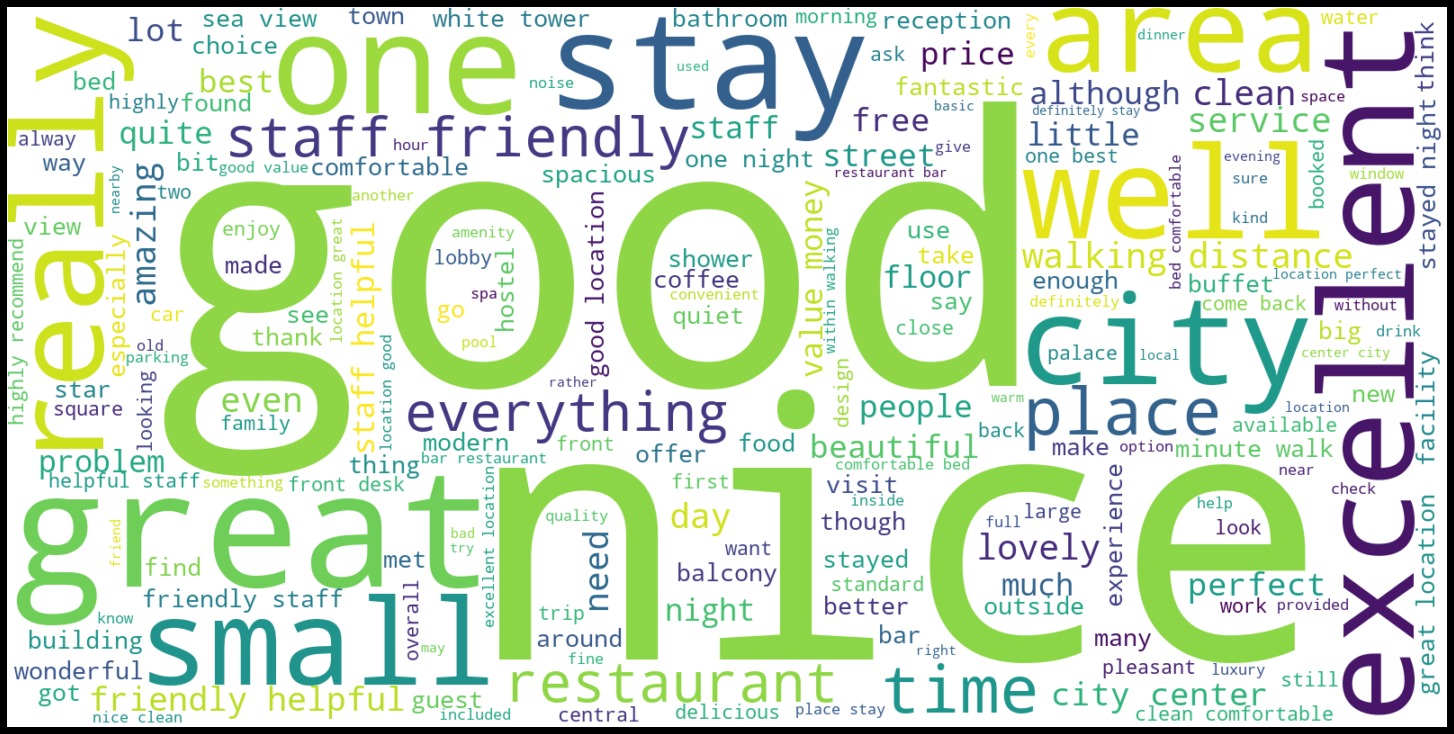

In [17]:
positive_wordcloud = WordCloud(width=1600, height=800, stopwords=stop_words, background_color="white").generate(positive_reviews_text)
plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

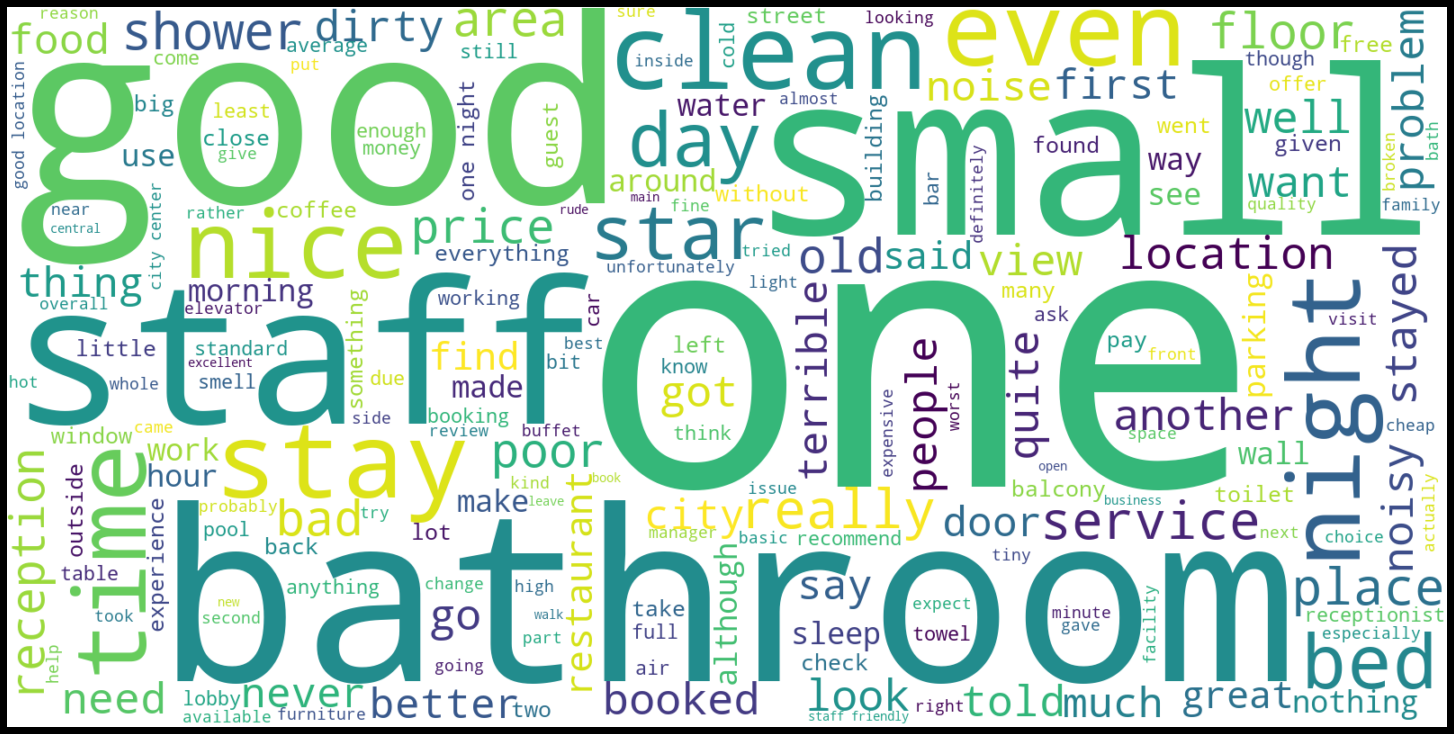

In [18]:
negative_wordcloud = WordCloud(width=1600, height=800, stopwords=stop_words, background_color="white").generate(negative_reviews_text)
plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [19]:
reviews['sentiment_label'] = reviews['sentiment'].apply(lambda row: row['label'])
reviews['sentiment_score'] = reviews['sentiment'].apply(lambda row: row['score'])
reviews

,hotel,user,reviewed_date,visit_date,rating,title,text,preprocessed_text,sentiment,sentiment_label,sentiment_score
0,ad Imperial Palace Hotel Thessaloniki,tehgr3g,"March 28, 2022",March 2022,5.0,Excellent Stay in Thessaloniki Center !,Best Value for Money Hotel located in the hear...,"best,value,money,hotel,heart,top,spot,biggest,...","{'label': 'POSITIVE', 'score': 0.9989263415336...",POSITIVE,0.998926
1,ad Imperial Palace Hotel Thessaloniki,gopalakrishnank769,"December 5, 2021",December 2021,4.0,Good hotel with professional staff,AD Imperial Palace hotel's location is almost ...,"ad,imperial,palace,hotel,location,almost,perfe...","{'label': 'POSITIVE', 'score': 0.9989269375801...",POSITIVE,0.998927
2,ad Imperial Palace Hotel Thessaloniki,TasosAnth,"November 17, 2021",November 2021,3.0,Palace only in the lobby,This hotel is located near the center of Thess...,"hotel,near,center,everything,walkable,distance...","{'label': 'NEGATIVE', 'score': 0.9995115995407...",NEGATIVE,0.999512
3,ad Imperial Palace Hotel Thessaloniki,ADtrip27,"November 6, 2021",November 2021,3.0,Old-fashioned hotel,I spent one night in this hotel ideally locate...,"spent,one,night,hotel,ideally,next,restaurant,...","{'label': 'POSITIVE', 'score': 0.9988138675689...",POSITIVE,0.998814
4,ad Imperial Palace Hotel Thessaloniki,Alex J,"March 17, 2020",April 2019,4.0,A reasonably good hotel,"We were on a group tour, a large group of abou...","group,tour,large,group,people,hotel,chosen,tou...","{'label': 'POSITIVE', 'score': 0.9988769888877...",POSITIVE,0.998877
...,...,...,...,...,...,...,...,...,...,...,...
14182,Zeus Is Loose Hostel,JenniferS8321,"July 15, 2021",June 2021,5.0,Very nice hostel!!!,Best hostel I could imagine. Nice and motivate...,"best,hostel,could,imagine,nice,team,organized,...","{'label': 'POSITIVE', 'score': 0.9989344477653...",POSITIVE,0.998934
14183,Zeus Is Loose Hostel,timlucier,"June 27, 2021",May 2021,5.0,Best Hostel Ever,This is hands down the highest-quality hostel ...,"hand,hostel,ever,stayed,super,comfortable,room...","{'label': 'POSITIVE', 'score': 0.9989349246025...",POSITIVE,0.998935
14184,Zeus Is Loose Hostel,Ladikos2,"April 15, 2021",September 2020,5.0,"Amazing location , hospitality and view",Great experience as me and my friend slept the...,"great,experience,friend,slept,day,city,staff,s...","{'label': 'POSITIVE', 'score': 0.9989383816719...",POSITIVE,0.998938
14185,ZH Luxury Suites City Center View,Cristian D,"August 6, 2021",August 2021,3.0,Decent for one night.,"· Excellent location, very close to stores, ve...","excellent,location,close,store,close,restauran...","{'label': 'POSITIVE', 'score': 0.9987927675247...",POSITIVE,0.998793


In [20]:
grouped = reviews.groupby(by=['hotel', 'sentiment_label']).agg('mean')
grouped

rating  \
hotel                                 sentiment_label             
Aegeon Hotel                          NEGATIVE         2.285714   
                                      POSITIVE         3.978022   
Alexandria Hotel                      NEGATIVE         2.230769   
                                      POSITIVE         3.571429   
Amalia Hotel                          NEGATIVE         2.000000   
...                                                         ...   
Zeus Is Loose Hostel                  POSITIVE         4.916667   
ad Imperial Palace Hotel Thessaloniki NEGATIVE         2.062500   
                                      POSITIVE         4.322581   
ad Imperial Plus Hotel Thessaloniki   NEGATIVE         3.000000   
                                      POSITIVE         5.000000   

                                                       sentiment_score  
hotel                                 sentiment_label                   
Aegeon Hotel                          NEGATIVE                0.996995  
                                      POSITIVE                0.997569  
Alexandria Hotel                      NEGATIVE                0.995211  
                                      POSITIVE                0.998212  
Amalia Hotel                          NEGATIVE                0.998678  
...                                                                ...  
Zeus Is Loose Hostel                  POSITIVE                0.998923  
ad Imperial Palace Hotel Thessaloniki NEGATIVE                0.999368  
                                      POSITIVE                0.998739  
ad Imperial Plus Hotel Thessaloniki   NEGATIVE                0.999508  
                                      POSITIVE                0.998918  

[233 rows x 2 columns]

In [21]:
top_n = 10
positive_queue = PriorityQueue()
negative_queue = PriorityQueue()
for index, row in grouped.iterrows():
    if index[1] == 'POSITIVE':
        if positive_queue.qsize() < top_n:
            positive_queue.put((row['sentiment_score'], index[0]))
        elif positive_queue.queue[0][0] < row['sentiment_score']:
            positive_queue.get()
            positive_queue.put((row['sentiment_score'], index[0]))
    elif index[1] == 'NEGATIVE':
        if negative_queue.qsize() < top_n:
            negative_queue.put((row['sentiment_score'], index[0]))
        elif negative_queue.queue[0][0] > row['sentiment_score']:
            negative_queue.get()
            negative_queue.put((row['sentiment_score'], index[0]))

In [22]:
positive_reviews = []
negative_reviews = []
for index in range(top_n):
    positive_reviews.append(positive_queue.queue[(top_n-1)-index][1])
    negative_reviews.append(negative_queue.queue[(top_n-1)-index][1])

In [23]:
positive_reviews

['Sky Studios',
 'Limani Luxury Rooms',
 'Mystique Luxury Suites',
 'NOA Premium Stay',
 'Korali Studios Hotel',
 'ONOMA Hotel',
 'Filoxenia',
 'Gatto Perso Luxury Studio Apartments',
 'Zeus Is Loose Hostel',
 'The Caravan']

In [24]:
negative_reviews

['Andromeda Thessaloniki',
 'BEST WESTERN St. George Asprovalta Hotel Thessaloniki',
 'Bahar boutique hotel',
 'Amalia Hotel',
 'Antigon Urban Chic Hotel',
 'Aegeon Hotel',
 'Anatolia Hotel Thessaloniki',
 'Argo Hotel',
 'Astoria Hotel',
 'Hotel Atlantis']

In [ ]:
reviews.to_csv('sentiment_preprocessed_reviews.csv', index=False, encoding='utf-8-sig', quoting=csv.QUOTE_ALL)